# [E-03] Camera sticker app

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

* dlib: 얼굴의 랜드마크를 분리하기 위해서 사용

## 1. Image preparation

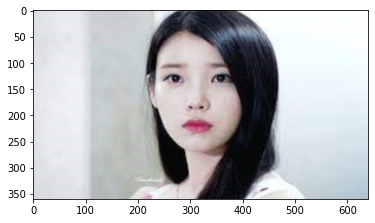

In [2]:
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/iu_image_test.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640, 360))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

* OpenCV를 이용하여 이미지를 읽어온 후, 출력
* resize와 cvtColor을 이용하여 이미지의 사이즈와 색 처리
* cvtColor를 사용하는 이유: OpenCV는 BGR 포멧을 사용하기 때문에, RGB 포멧으로 변환해야함

## 2. Face detection

rectangles[[(221, 77) (407, 263)]]


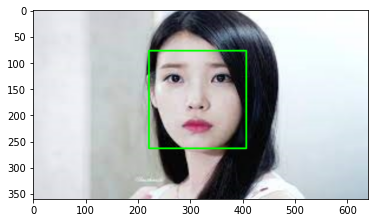

In [3]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

* dlib을 이용하여, 이미지 내 얼굴 영역의 좌표를 출력하고, box 처리
* detector_hog: 이미지 피라미드에서 얼굴을 다시 검출하면, 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능 (두 번째 파라미터 = 이미지 피라미드의 수)
* dlib detector는 dlib.rectangles 타입의 객체를 반환
* dlib.rectangle 객체는 left(), top(), right(), bottom(), height(), width() 등의 함수를 포함

## 3. Face landmark

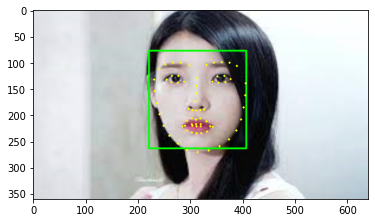

In [4]:
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

* top-down 방식과 이미지 내 box를 이용하여 landmark를 출력
* 아래의 첨부된 이미지는 landmark의 순서

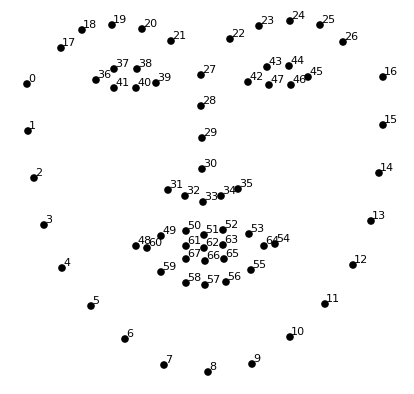

* list_landmarks 변수는 68개의 tuple (x, y)로 이루어져 있는 리스트
* 특정 landmark 포인트를 이용하여 스티커를 부착

## 4. Apply sticker

### 스티커의 위치와 크기를 구하는 방법

1. 스티커 위치
$$ x = x_{nose}$$
$$ y = y_{nose} - \cfrac{width}{2}$$

2. 스티커 크기
$$ width = height = width_{bbox}$$

In [5]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33])
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x, y): (%d, %d)'%(x, y))
    print('(w, h): (%d, %d)'%(w, h))

(311, 191)
(x, y): (311, 191)
(w, h): (187, 187)


* 고양이 수염 스티커를 붙이기 위해서, 코의 중심 좌표를 이용(landmark[33])
* 스티커의 위치(x, y)와 크기(w, h)를 출력

(187, 187, 3)


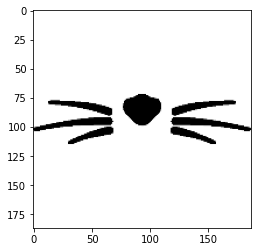

In [6]:
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
print(img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

* 스티커의 이미지를 읽어온 후, 위에서 계산한 크기(w, h)를 이용하여 스티커를 resize

In [7]:
refined_x = x - w // 2
refined_y = y - w // 2
print('(x, y): (%d, %d)'%(refined_x, refined_y))

(x, y): (218, 98)


* 위에서 계산한 위치(x, y)를 이미지의 시작점에 맞게 재설정

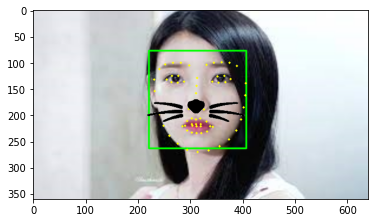

In [8]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)
#     np.where(img_sticker==0, img_sticker, sticker_area).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

* 원본 이미지에 스티커 적용 후 결과 출력
* 이미지에 스티커를 적용할 시, 스티커의 흰색 배경이 함께 나타나는 현상이 발생(마지막 회고 부분에 기술)

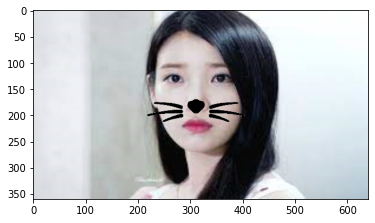

In [9]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

* box와 landmark를 제거한 후, 최종 결과 출력

## 5. 여러 종류의 이미지 테스트

### 5.1. 밝기가 어두운 이미지

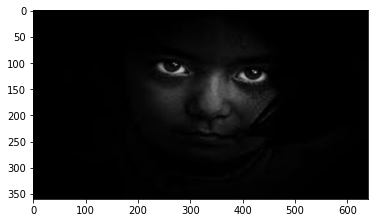

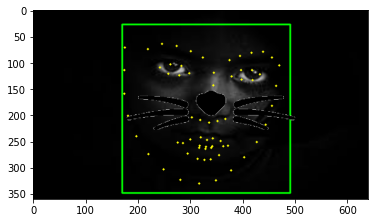

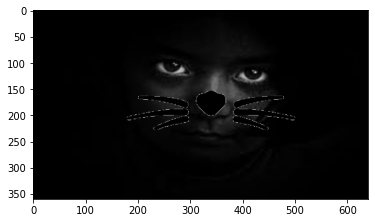

In [10]:
# 원본 이미지 불러오기
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/image_dark.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640, 360))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

# 이미지 위에 얼굴의 box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# landmark 모델 불러오기
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    
# 스티커 이미지를 읽어와서 resize
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x - w // 2
refined_y = y - w // 2

# 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 5.2. 촬영 거리가 먼 인물 이미지

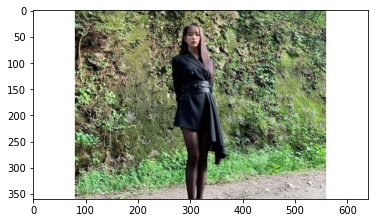

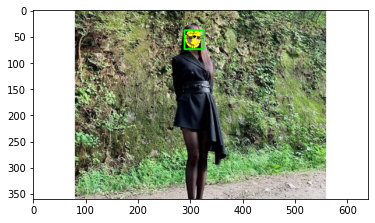

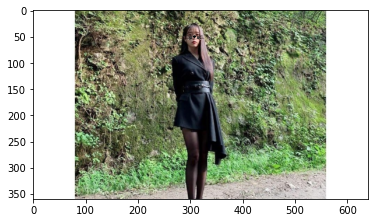

In [11]:
# 원본 이미지 불러오기
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/iu_image_far.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640, 360))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

# 이미지 위에 얼굴의 box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# landmark 모델 불러오기
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    
# 스티커 이미지를 읽어와서 resize
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x - w // 2
refined_y = y - w // 2

# 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 5.3. 눈이 보이지 않는 선글라스를 낀 인물 이미지

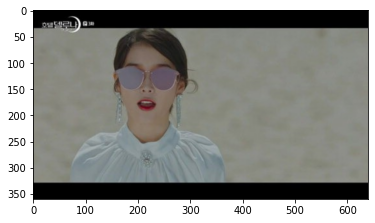

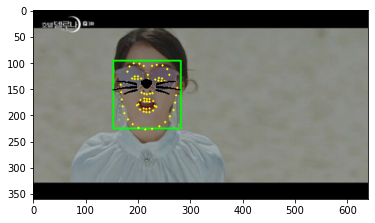

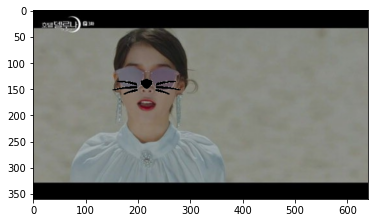

In [12]:
# 원본 이미지 불러오기
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/iu_image_sunglasses.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640, 360))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

# 이미지 위에 얼굴의 box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# landmark 모델 불러오기
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    
# 스티커 이미지를 읽어와서 resize
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x - w // 2
refined_y = y - w // 2

# 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 5.4. 눈이 보이는 안경을 쓴 인물 이미지

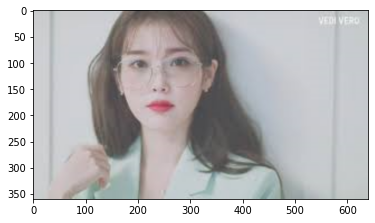

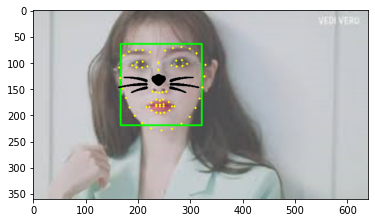

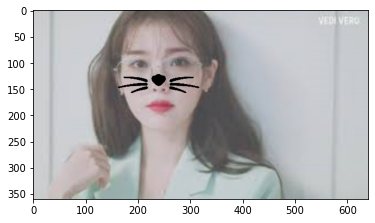

In [13]:
# 원본 이미지 불러오기
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/iu_image_sunglasses_2.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640, 360))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

# 이미지 위에 얼굴의 box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# landmark 모델 불러오기
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    
# 스티커 이미지를 읽어와서 resize
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x - w // 2
refined_y = y - w // 2

# 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 5.5. 얼굴의 각도가 틀어진 이미지

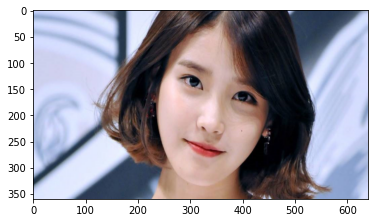

rectangles[[(216, 93) (439, 316)]]


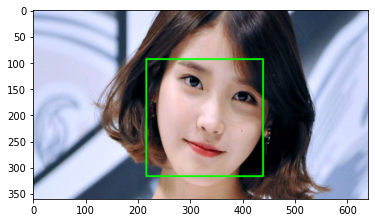

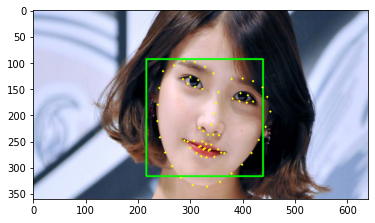

In [14]:
# 원본 이미지 불러오기
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/iu_image_tilt.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640, 360))
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)

# 이미지 위에 얼굴의 box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# landmark 모델 불러오기
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

degree:  -17.241459398939973
(334, 237)
(x, y): (222, 125)
(w, h): (224, 224)


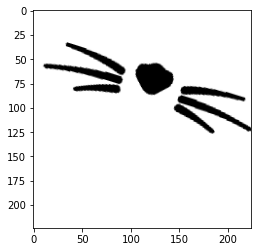

(x, y): (222, 125)


In [15]:
# 이미지 속 인물의 얼굴이 틀어진 각도 계산
import math

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x_tilt = abs(landmark[42][0] - landmark[39][0])
    y_tilt = abs(landmark[42][1] - landmark[39][1])
    z_tilt = math.sqrt(x_tilt ** 2 + y_tilt ** 2)
    degree_tilt = -math.degrees(math.acos(x_tilt / z_tilt))
    
    print('degree: ', degree_tilt)

# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33])
    x = landmark[33][0] - dlib_rect.width() // 2
    y = landmark[33][1] - dlib_rect.width() // 2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x, y): (%d, %d)'%(x, y))
    print('(w, h): (%d, %d)'%(w, h))

# 스티커 이미지를 읽어와서 resize
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

tilt = cv2.getRotationMatrix2D((x, y), degree_tilt, 1)
tilt_sticker = cv2.warpAffine(img_sticker, tilt, (w, h), borderValue=(255,255,255))
tilt_sticker = cv2.resize(tilt_sticker, (w, h))

plt.imshow(tilt_sticker)
plt.show()

# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x 
refined_y = y 
print('(x, y): (%d, %d)'%(refined_x, refined_y))

### 스티커 회전

* 얼굴의 각도가 틀어져 있는 이미지에 스티커를 붙일 때, 얼굴의 각도에 따라서 스티커도 회전하게끔 설정
* 방식은 다음과 같음
    1. 양쪽 눈의 landmark(39번과 42번)을 이용
    2. 두 landmark의 x축 거리(x_tilt)와 y축 거리(y_tilt)를 계산
    3. 앞서 구한 x축 거리와 y축 거리를 이용하여 두 점 사이의 거리(z_tilt)를 계산
    4. arccos에 x_tilt/z_tilt를 대입하여 두 점 사이의 각도를 계산
    5. arccos을 이용하여 계산된 각도는 라디안 값이기 때문에, degree로 변환
    6. 이후 아래의 코드에서 cv2.getRotationMatrix2D와 cv2.warpAffine을 이용하여 스티커를 회전
    7. cv2.warpAffine를 사용할 때, 각도만 회전시키면 스티커 이미지의 배경이 검은색인 부분이 생기는데, 배경을 통일시키기 위해서 borderValue를 설정
    8. 마지막으로 회전한 스티커를 다시 resize
    9. 이후 과정에서 (refined_x, refined_y) 값을 알맞게 변경해주어야 함

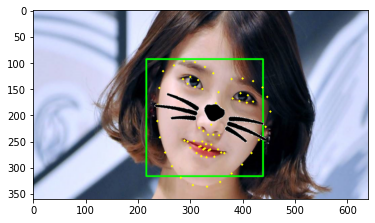

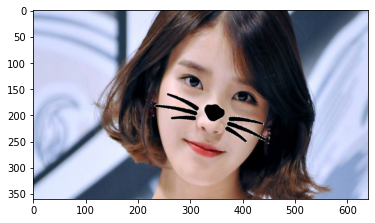

In [16]:
# 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(tilt_sticker==255, sticker_area,tilt_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(tilt_sticker==255, sticker_area,tilt_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

---

## 6. 결과
* 기본적인 정면 이미지, 전체적으로 어두운 이미지, 먼 거리에서 촬영한 이미지, 안경을 쓰고 있는 이미지(눈이 보이지 않는 경우, 눈이 보이는 경우), 얼굴의 각도가 틀어진 이미지 모두 스티커를 붙이는 데 성공
* 다만, 얼굴의 일부분이 잘린 이미지나, 이목구비가 뚜렷하지 않은 이미지들에 대해서는 스티커를 붙이는 데 실패
* 스티커를 붙이는 데 실패한 이미지들의 공통점은 landmark가 생성되지 않았다는 점
* 따라서, 얼굴의 전체적인 모습이 나오지 않았거나 뚜렷하지 않은 이미지들은 landmark를 생성하기에 어려움이 있다고 판단

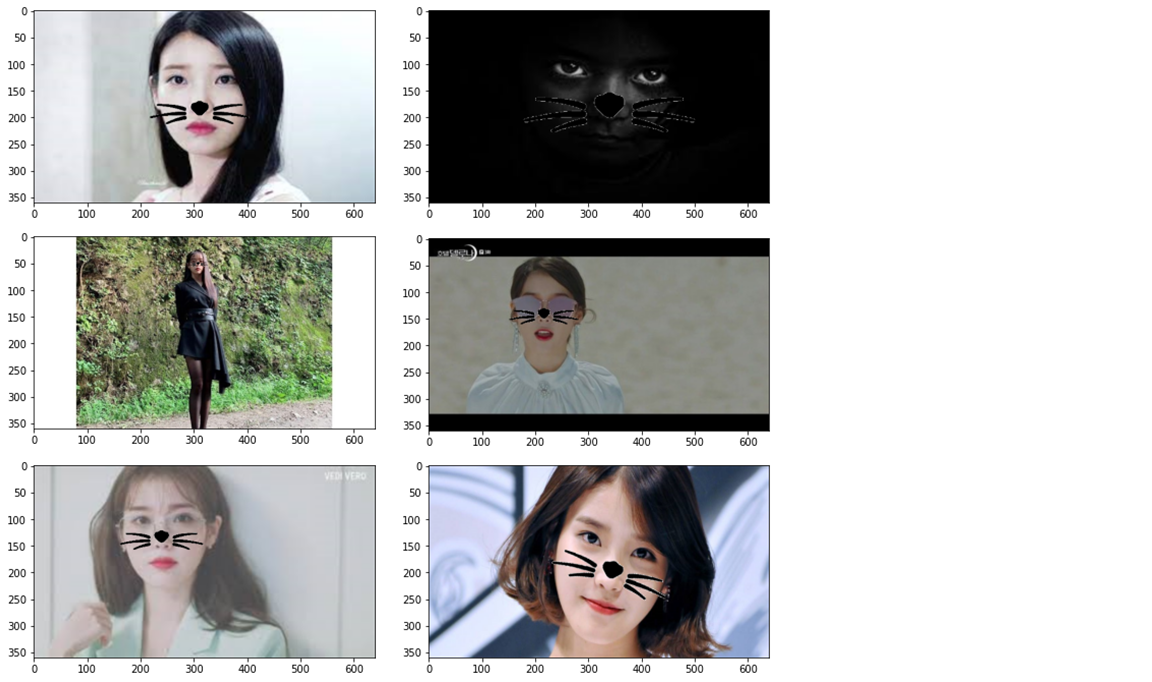

## 7. 회고

### 안경을 쓰고 있는 인물 이미지
* 눈이 보이지 않는 경우(선글라스를 낀 인물 이미지)에는 landmark 생성이 힘들다고 예상했지만, 예상과는 다르게 landmark가 생성되었다. 이 경우 일부 landmark의 위치가 인물의 정확한 얼굴 형이나 눈썹 모양과는 다르지만, 선글라스로 가려지지 않은 부분을 이용하여 landmark를 생성한 것으로 판단된다. 

* 눈이 보이는 경우(안경을 낀 인물 이미지)에서는 모든 landmark의 위치가 정상적으로 생성되었다. 이는 눈과 눈썹, 전체적인 얼굴 형이 잘 보이기때문이라고 판단된다.

* landmark가 제대로 생성되지 않았던 이미지들과 비교했을 때, 다음의 조건을 충족한다면 이미지의 일부가 가려져도 landmark가 생성되는 것이 아닌가 판단된다.
    + 얼굴 안쪽의 일부(코, 눈)가 가려져도, 얼굴의 전체적인 윤곽(외곽에 위치한 landmark, 전체적인 얼굴 형을 나타내는 landmark, 눈썹을 나타내는 landmark)이 잘 나타나는 경우


### 스티커 적용 옵션
* 스티커 색상 문제: 이미지 위에 스티커를 추가할 때, 스티커의 배경이 투명한 것이 아니라 흰색으로 나타나는 문제가 있었다. 해당 문제는, np.where()에서 img_sticker의 값을 0이 아니라, 255로 설정하니 해결되었다. 검은색을 의미하는 픽셀 값은 0이기 때문에, img_sticker에 0을 대입해야 할 것 같은데, 왜 255 값을 넣어줬을 때 올바르게 스티커가 추가된 것인지는 잘 모르겠다. (np.where()는 img_sticker가 255이면 sticker_area의 값을 위치시키고, 아니라면 img_sticker의 값을 위치시키라는 의미이다.)

### 스티커 회전
* 스티커를 회전시키는 방법은 여러가지가 있겠지만, 양쪽 눈의 landmark (39번, 42번) 사이의 거리를 이용하여 각도를 계산했다. 계산한 각도는 실제 이미지 내의 인물의 얼굴이 얼마나 틀어져 있는지를 나타내는 척도이며, 해당 각도를 이용하여 스티커도 회전시켰다. 위에서 작성한 각도 계산 코드를 조금만 수정하면, 모든 이미지에 대해서 스티커 회전을 쉽게 적용시킬 수 있을거라고 생각된다. (각도 계산 코드에서, 계산된 각도를 음수로 변환하여 사용하였는데, if 조건문에서 x_tilt와 y_tilt 값이 음수인지 양수인지를 판단하는 조건식을 잘 이용한다면 degree_tilt 값의 부호나 회전 방향 등을 쉽게 계산할 수 있을거라고 생각함)
* 스티커를 회전시킨 후, 스티커의 위치(refined_x, refined_y)를 조절하는 과정에서 어려움을 많이 느꼈다. 위치를 재설정하는 과정은 직접 스티커가 부착된 이미지를 출력하여 확인한 후, 조절하는 방법으로 진행하였다. 이 과정을 좀 더 쉽게 해결할 수 있는 방법에 대해서 더 찾아봐야 할 것 같다.